### late-stage diversification, sp3 acid druglike with sp3 amine

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem.Draw import MolDrawing, DrawingOptions, MolToImage

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

import numpy as np
import pandas as pd
import os

from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map

In [2]:
def apply_amat(acid,acid_match,amine,amine_match,rmat):
    """
    needs the smarts of the acid and amine pre-defined. maybe an external dictionary.
    """
    # combine molecules and make a writable version
    both = Chem.CombineMols(acid,amine)
    bothW = Chem.RWMol(both)
    Chem.Kekulize(both,clearAromaticFlags=True)
    Chem.Kekulize(bothW,clearAromaticFlags=True)
    
    # get the indices for the acid and amine matches. 
    amine_atoms = both.GetSubstructMatch(group_dict[amine_match])
    acid_atoms = both.GetSubstructMatch(group_dict[acid_match])
    
    if not (amine_atoms and acid_atoms):
        print("substruct match not found")
        return
    # join the indices
    atom_list = amine_atoms + acid_atoms
#     print(atom_list)
    
    # go through the amat to find places where the change is not 0
    side_len = len(rmat)
    
    if side_len != len(atom_list):
        print("matrix length does not equal number of matched atoms")
        return
    for r in range(side_len):
        for c in range(r+1,side_len):
            bond_order_change = rmat[r][c]
            if bond_order_change != 0: 
                atom1 = atom_list[amat2ind[r]]
                atom2 = atom_list[amat2ind[c]]
                
                # get the current bond order
                current_bond = both.GetBondBetweenAtoms(atom1,atom2)
                if current_bond: 
                    current_bond_order = current_bond.GetBondTypeAsDouble()                
                else: 
                    current_bond_order = 0
                    
                new_bond_order = current_bond_order + bond_order_change
                
                if new_bond_order not in [0,1,2,3]:
                    print("invalid new bond order")
                    return None
                # make bond changes
                
                bothW.RemoveBond(atom1,atom2)
                
                if new_bond_order > 0:
                    bothW.AddBond(atom1,atom2, bond_dict[new_bond_order])

    try:
        Chem.SanitizeMol(bothW)

    except:
#         print("illegal structure")
        return None

    # may need to become smiles if we want to multitarget, as well as have fragments included.
    return bothW


### we tag the alpha and beta carbons as isotopes, for more precise matching

In [3]:
sp3_acid_smiles = "O=C1N(C2=CC=C([16C@H]([17C]([18O])=[17O])[15C]C)C=C2)CC3=CC=CC=C31"

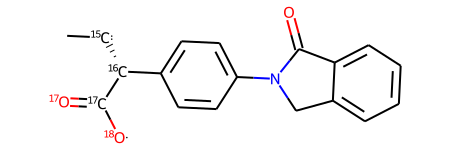

In [4]:
# sp3_acid_smiles = '[17O]=[17C]([18O])[16C]([15C]c1cnc[nH]1)N1C(=O)c2ccccc2C1=O'
enamine_acid = Chem.MolFromSmiles(sp3_acid_smiles)
enamine_acid

In [5]:
sp3_amine_smiles = "[15N][14C@H]([13C])C1=CC=CC=C1"

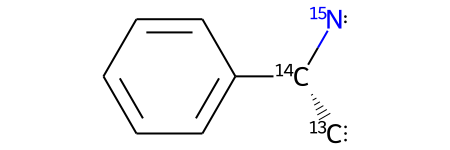

In [6]:
# sp3_amine_smiles = "[15N][14C][13C]C1CCC(N)C1"
enamine_amine = Chem.MolFromSmiles(sp3_amine_smiles)
enamine_amine

In [7]:
am2 = Chem.MolFromSmarts("[CX3]=[CX3][NH2]")
ac2 = Chem.MolFromSmarts("[CX3][CX3][CX3](=O)[OX2H1]")
am3 = Chem.MolFromSmarts("[13C][14C][15N]")
ac3 = Chem.MolFromSmarts("[15C][16C][17C](=[17O])[18O]")


group_dict = {"ac2":ac2, "ac3":ac3,"am2":am2,"am3":am3}

# make a mapping dictionary.
# the dictionary is basically, first entry is amine C1. second entry is amine C2. 
# this changes depending on the matrix, and how the smarts for the matcher is written. 

# number of entries in the amat
amat_indices = range(8)
# which entry each index should map to
mapping_order = [0,1,3,4,5,2,6,7]
# mapping_order = [3,4,5,0,1,2,6,7]

# amat index -> amine/acid match index
amat2ind = {k:v for k,v in zip(amat_indices, mapping_order)}

bond_dict = {1:Chem.BondType.SINGLE, 2:Chem.BondType.DOUBLE, 3:Chem.BondType.TRIPLE}

### check that the substruct matching hits the right region

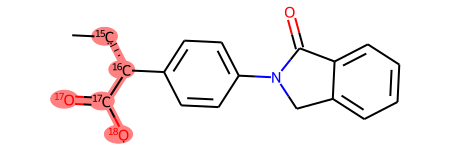

In [8]:
enamine_acid.GetSubstructMatch(ac3)
enamine_acid

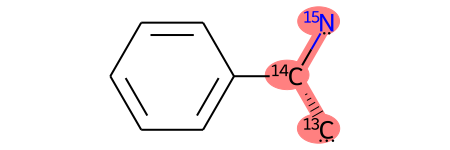

In [9]:
enamine_amine.GetSubstructMatch(am3)
enamine_amine

### the product matrices and product distances need to be computed before the code below is run.

In [10]:
if not os.path.exists("./ac3drug_am3small/"):
    os.makedirs("./ac3drug_am3small/")

In [11]:
def run_enumeration(file_tag):
    index_start = file_tag * 100000
    file_tag = str(file_tag).zfill(2)

    dmats = np.load(f"../rxn_mats/dmats_ac3_am3_{file_tag}.npy")
    out_file = open(f"./ac3drug_am3small/matrix_coupling_{file_tag}.csv","w")
    out_file.write("rmat_tag,pdt_smiles\n")
    
    for i, dmat in enumerate(dmats):
        
        try:
            matrix_index = index_start + i
            m = apply_amat(enamine_acid,"ac3",enamine_amine,"am3",dmat)
            s = Chem.MolToSmiles(m,isomericSmiles=True)
            out_file.write(f"{index_start+i},{s}\n")
        except:
            continue
    out_file.close()
    

### run the coupling script

In [12]:
# 15 minutes on 1 core
for i in tqdm(range(18)):
    run_enumeration(i)

  0%|          | 0/18 [00:00<?, ?it/s]

### for processing - we only want products that have at least one atom from the acid, and amine portions

In [13]:
acid_parts = ["[15C]","[16C]","[17C]","[15c]","[16c]","[17c]","[17O]","[18O]","[17o]","[18o]"]
amine_parts = ["[13C]","[14C]","[13c]","[14c]","[15N]","[15n]"]

def check_smiles(s):
    coupled_smiles = []
    split_smiles = s.split(".")
    
    for ss in split_smiles:
        if any([i in ss for i in acid_parts]) and any([i in ss for i in amine_parts]):
            coupled_smiles.append(ss)
    if len(coupled_smiles) == 0:
        return "C"
    
    else:
        atom_counts = [count_atoms(s) for s in coupled_smiles]
        largest_frag_ind = np.argmax(atom_counts)
        return coupled_smiles[largest_frag_ind]
            
def count_atoms(s):
    alphab = "CONcon"
    return len([i for i in s if i in alphab])            

In [14]:
all_coupling_data = []
for file_tag in tqdm(range(18)):
    
    distance_data = pd.read_csv(f"../data_files/smiles_with_all_dists/smiles_with_all_dists_{str(file_tag).zfill(2)}.csv")
    coupling_data = pd.read_csv(f"./ac3drug_am3small/matrix_coupling_{str(file_tag).zfill(2)}.csv")

    raw_tags = list(coupling_data.rmat_tag - file_tag*100000)
    coupling_dists = list(distance_data.iloc[raw_tags].ac3_am3)

    coupling_data["distance"] = coupling_dists


    largest_frag = []
    for s in coupling_data.pdt_smiles:
        largest_frag.append(check_smiles(s))
    coupling_data["largest_frag"] = largest_frag
    
    # remove duplicates
    coupling_data.sort_values("distance",inplace=True)
    coupling_data.drop_duplicates(subset="largest_frag",inplace=True)
    coupling_data.sort_values("rmat_tag",inplace=True)


    all_coupling_data.append(coupling_data)

  0%|          | 0/18 [00:00<?, ?it/s]

### clean up

In [15]:
all_coupling_df = pd.concat(all_coupling_data)
all_coupling_df.sort_values("distance",inplace=True)

In [17]:
all_coupling_df.drop_duplicates(subset="largest_frag",inplace=True)
all_coupling_df.sort_values("rmat_tag",inplace=True)

all_coupling_df = all_coupling_df[all_coupling_df.largest_frag!="C"].copy()

### ring strain filter

In [20]:
ring_triple_bond = Chem.MolFromSmarts("[*!R0]#[*!R0]")
cyclopropene = Chem.MolFromSmarts("[*!R0]1=[*!R0]~[*]1")
ring_allene = Chem.MolFromSmarts("[*!R0]=[*!R0]=[*!R0]")
ab_211_2 = Chem.MolFromSmarts("*1(~*2)=*~*~*2~*1")
ab_211_1 = Chem.MolFromSmarts("*1(~*2)=*~*2~*~*1")
ab_220_2 = Chem.MolFromSmarts("*12~*~*~*1=*~*2") 
ab_220_0 = Chem.MolFromSmarts("*1(~*~*2)=*2~*~*1")
ab_221_2 = Chem.MolFromSmarts("*1(~*2)~*~*~*2=*~*1")
ab_221_1 = Chem.MolFromSmarts("*12=*~*(~*~*2)~*~*1")
ab_222_2 = Chem.MolFromSmarts("*12~*~*~*(~*~*2)=*~*1")
ab_210_2 = Chem.MolFromSmarts("*12~*~*=*1~*2")
ab_210_0 = Chem.MolFromSmarts("*1(~*2)=*2~*~*1")
ab_210_1 = Chem.MolFromSmarts("*12~*~*~*1=*2")
ab_114_1 = Chem.MolFromSmarts("*1(~*2)=*~*2~*~*~*~*1")
ab_114_4 = Chem.MolFromSmarts("*1(~*2)=*~*~*~*~*2~*1")
ab_123_1 = Chem.MolFromSmarts("*12=*~*(~*~*~*2)~*~*1")
ab_123_2 = Chem.MolFromSmarts("*12=*~*~*(~*~*~*2)~*1")
ab_123_3 = Chem.MolFromSmarts("*1(~*~*2)=*~*~*~*2~*1")

myrules = [ring_triple_bond,cyclopropene,ring_allene,ab_211_2,ab_211_1,ab_220_2,ab_220_0,
           ab_221_2,ab_221_1,ab_222_2,ab_210_2,ab_210_0,ab_210_1,ab_114_1,ab_114_4,ab_123_1,ab_123_2,ab_123_3]

In [21]:
def check_bredt(s):
    m = Chem.MolFromSmiles(s)

    if not any([m.HasSubstructMatch(patt) for patt in myrules]):
        return True
    else:
        return False

In [22]:
# 1 minute
bredt_check = []

for fr in tqdm(all_coupling_df.largest_frag):
    bredt_check.append(check_bredt(fr))

  0%|          | 0/94548 [00:00<?, ?it/s]

In [23]:
all_coupling_df["bredt"] = bredt_check
all_coupling_df_bredt = all_coupling_df[all_coupling_df.bredt].copy()
all_coupling_df_bredt.reset_index(drop=True,inplace=True)

### clean up the isotope tags

In [24]:
acid_parts = ["[15C]","[16C]","[17C]","[15c]","[16c]","[17c]","[17O]","[18O]","[17o]","[18o]"]
amine_parts = ["[13C]","[14C]","[13c]","[14c]","[15N]","[15n]"]

# replace isotopes with non-isotopes
def clean_structure(s):
    temp = s
    
    for i in acid_parts + amine_parts:
        temp = temp.replace(i,i[-2])
    return temp

# replace isotopic stereocenters with non-isotopic ones
def clean_stereo_C(s):
    temp = s
    iso = ["[16CH]","[16C@H]","[16C@@H]","[14CH]","[14C@H]","[14C@@H]"]
    non_iso = ["C","[C@H]","[C@@H]","C","[C@H]","[C@@H]"]
    for i in range(len(iso)):
        temp = temp.replace(iso[i],non_iso[i])
        
    return temp

In [25]:
s_cleaned = []
for s in tqdm(list(all_coupling_df_bredt['largest_frag'])):
    s_cleaned.append(clean_structure(s))

  0%|          | 0/92452 [00:00<?, ?it/s]

In [26]:
stereo_cleaned = []
for s in s_cleaned:
    stereo_cleaned.append(clean_stereo_C(s))
    
all_coupling_df_bredt["largest_cleaned"] = stereo_cleaned

In [27]:
all_coupling_df_bredt.sort_values("distance",inplace=True)
all_coupling_df_bredt.drop_duplicates(subset="largest_cleaned",inplace=True)

### save.

In [28]:
all_coupling_df_bredt[["rmat_tag","distance","largest_frag","largest_cleaned"]].to_csv("./ac3drug_am3small/ac3drug_am3small_smiles.csv",index=False)